In [16]:
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [4]:
#Plant states from index 0 - 5
plant_states = ["Saludable","Estresada","Deshidratada","Exceso de riego","Deficiencia nutrientes","Enferma"]

In [43]:
# Load the data
dataset = pandas.read_csv('arduinodata_with_plant_state2.csv', parse_dates=['timestamp'])

# Drop the 'id' column
dataset.drop(['id','deviceid'], axis=1, inplace=True)

#Set timestamp as index
dataset.set_index('timestamp', inplace=True)

print(dataset)

                            soilmoisture  temperature  airhumidity  \
timestamp                                                            
2024-04-26 23:44:05.022556            86         23.8           26   
2024-04-26 23:15:24.367992            86         24.1           24   
2024-04-26 22:46:54.191467            86         24.4           20   
2024-04-26 22:18:22.945400            86         24.7           17   
2024-04-26 21:49:41.969129            85         25.0           16   
...                                  ...          ...          ...   
2024-04-14 15:55:52.815886            91         23.4           35   
2024-04-14 15:27:01.788713            91         23.2           35   
2024-04-14 14:54:33.597601            88         28.2           28   
2024-04-14 13:51:05.035296            74         27.0           25   
2024-04-14 13:20:30.915587            76         25.2           29   

                            lightlevel  irrigationamount  state  
timestamp              

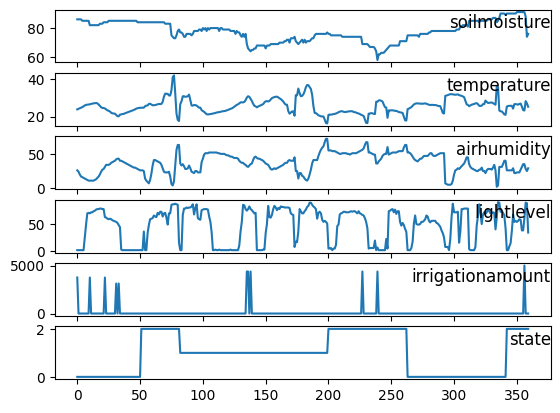

In [44]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [25]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pandas.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     
 if i == 0:
     names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
 # put it all together
 agg = pandas.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
    
 return agg

In [30]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
#TODO: esto habría que cambiarlo para que haga las predicciones con los datos que tenga disponibles anteriormente
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var6(t)
1   0.848485   0.292969   0.342857        0.0       0.75        0.0      0.0
2   0.848485   0.304688   0.314286        0.0       0.00        0.0      0.0
3   0.848485   0.316406   0.257143        0.0       0.00        0.0      0.0
4   0.848485   0.328125   0.214286        0.0       0.00        0.0      0.0
5   0.818182   0.339844   0.200000        0.0       0.00        0.0      0.0


In [31]:
 #Cross validation
# split into train and test sets
values = reframed.values

train = values[:, :]
test = values[:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(359, 1, 6) (359,) (359, 1, 6) (359,)


Epoch 1/50
5/5 - 1s - 151ms/step - loss: 0.4684 - val_loss: 0.4549
Epoch 2/50
5/5 - 0s - 6ms/step - loss: 0.4513 - val_loss: 0.4419
Epoch 3/50
5/5 - 0s - 6ms/step - loss: 0.4383 - val_loss: 0.4294
Epoch 4/50
5/5 - 0s - 6ms/step - loss: 0.4258 - val_loss: 0.4170
Epoch 5/50
5/5 - 0s - 6ms/step - loss: 0.4133 - val_loss: 0.4044
Epoch 6/50
5/5 - 0s - 6ms/step - loss: 0.4006 - val_loss: 0.3915
Epoch 7/50
5/5 - 0s - 6ms/step - loss: 0.3875 - val_loss: 0.3781
Epoch 8/50
5/5 - 0s - 6ms/step - loss: 0.3740 - val_loss: 0.3642
Epoch 9/50
5/5 - 0s - 6ms/step - loss: 0.3598 - val_loss: 0.3495
Epoch 10/50
5/5 - 0s - 6ms/step - loss: 0.3449 - val_loss: 0.3341
Epoch 11/50
5/5 - 0s - 6ms/step - loss: 0.3292 - val_loss: 0.3177
Epoch 12/50
5/5 - 0s - 7ms/step - loss: 0.3125 - val_loss: 0.3003
Epoch 13/50
5/5 - 0s - 6ms/step - loss: 0.2948 - val_loss: 0.2820
Epoch 14/50
5/5 - 0s - 6ms/step - loss: 0.2762 - val_loss: 0.2627
Epoch 15/50
5/5 - 0s - 6ms/step - loss: 0.2564 - val_loss: 0.2428
Epoch 16/50
5/5 -

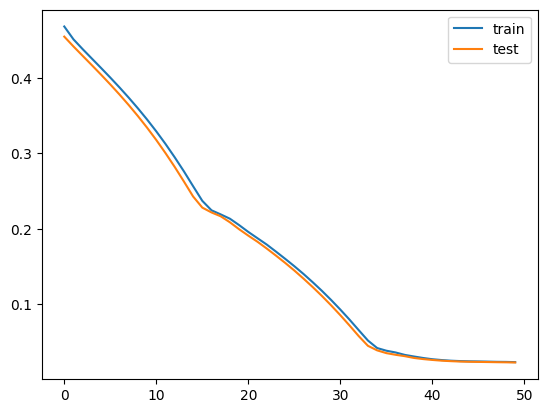

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = pandas.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = pandas.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None